# Lab 10: Explainability with Alibi
In this lab, you'll learn about the Alibi Explain library and implement global and local explanations of tabular and image classification models.

Alibi Explain is an open source Python library aimed at machine learning model inspection and interpretation. The focus of the library is to provide high-quality implementations of black-box, white-box, local and global explanation methods for classification and regression models.

Complete all the Deliverables mentioned below and show it to a TA for credit.

## Deliverables
- [ ] Finish all the TODOs in Section 1
- [ ] Generate PD Plots for chosen features. Discuss your findings about model performance with the TA.
- [ ] Play around with parameters for Anchor. Show final results to the TA.

## Getting Started
Clone this repository and run all cells in the notebook.

### Install Dependencies

For this assignment, make sure you have the required packages installed.
```
pip install -r requirements.txt
```
(If there are any major unsolvable issues prefer running this notebook on Google Colaboratory)

### Possible Issues with installing Alibi
`TypeError: issubclass() arg 1 must be a class` \
**Solution:** https://stackoverflow.com/questions/76313592/import-langchain-error-typeerror-issubclass-arg-1-must-be-a-class
<br><br>
If there's any more issues, please contact a TA to update this list (with a solution if its solved)

In [2]:
# !pip install alibi==0.9.5 alibi[tensorflow] numpy==1.23.5 pandas==1.5.3 scikit-image==0.22.0 scikit-learn==1.2.2 tensorflow<2.15.0

/bin/bash: line 1: 2.15.0: No such file or directory


In [5]:
!pip install alibi==0.9.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.0 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.6.4
    Uninstalling pydantic-2.6.4:
      Successfully uninstalled pydantic-2.6.4


In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [6]:
from alibi.explainers import PartialDependence, plot_pd

## Section 1 - Data + Modeling
In this section, we will be setting up our data, perform some preprocessing and train a model. You will be getting the freedom of choosing your own dataset and training a custom machine learning model on it.

**Note - Most of the code for this assignment is adapted from the Alibi example notebooks. Feel free to refer to their notebooks or official documentation for debugging (Links are in References section).**

### 1.1 Fetching the Dataset
Feel free to choose any tabular regression dataset, a good resource is the [Machine Learning with R Datasets GitHub](https://github.com/stedy/Machine-Learning-with-R-datasets).

In [16]:
!wget https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv

--2024-04-05 13:49:00--  https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54288 (53K) [text/plain]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  53.02K  --.-KB/s    in 0.01s   

2024-04-05 13:49:00 (4.61 MB/s) - ‘insurance.csv’ saved [54288/54288]



In [19]:
# TODO - Load your Dataset
df = pd.read_csv('insurance.csv', on_bad_lines='warn')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


### 1.2 Dataset Preprocessing
Finish all the TODOs in this section as per your dataset, this should be straightforward.

In [20]:
# extract feature names
feature_names = df.columns.tolist()
# TODO - remove the target feature from feature names
feature_names.remove('charges')

# TODO - define target names
target_names = ['charges']

# TODO - define categorical columns
categorical_columns_names = ['sex', 'smoker', 'region']

# define categorical and numerical indices for later preprocessing
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names]
numerical_columns_indices = [feature_names.index(fn) for fn in feature_names if fn not in categorical_columns_names]

# extract data
X = df[feature_names]
# TODO - define target column
y = df['charges']

# split data in train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [21]:
# define and fit the oridnal encoder
oe = OrdinalEncoder().fit(X_train[categorical_columns_names])

# transform the categorical columns to ordinal encoding
X_train.loc[:, categorical_columns_names] = oe.transform(X_train[categorical_columns_names])
X_test.loc[:, categorical_columns_names] = oe.transform(X_test[categorical_columns_names])

# convert data to numpy
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

# define categorical mappings
categorical_names = {i: list(v) for (i, v) in zip(categorical_columns_indices, oe.categories_)}

In [22]:
# [OPT] Print this variable to see different classes of categorical names
print(categorical_names)

{1: ['female', 'male'], 4: ['no', 'yes'], 5: ['northeast', 'northwest', 'southeast', 'southwest']}


In [23]:
# define numerical standard sclaer
num_transf = StandardScaler()

# define categorical one-hot encoder
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in categorical_names.values()],
    handle_unknown='ignore',
)

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_columns_indices),
        ('num', num_transf, numerical_columns_indices),
    ],
    sparse_threshold=0
)


In [24]:
# fit preprocessor
preprocessor.fit(X_train)

# preprocess train and test datasets
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

### 1.3 Training the Model
Run the cell to fit the model to the dataset

In [25]:
# define and fit regressor - feel free to play with the hyperparameters
predictor = RandomForestRegressor(random_state=0)
predictor.fit(X_train_ohe, y_train)

# compute scores
print('Train score: %.2f' % (predictor.score(X_train_ohe, y_train)))
print('Test score: %.2f' % (predictor.score(X_test_ohe, y_test)))

Train score: 0.97
Test score: 0.88


## Section 2 - Explainability with Alibi
In this section, we will be finally using Alibi to explain our trained model using different techniques. Fill in the TODOs and generate plots where required.

### 2.1 Partial Dependence (PD)

Partial Dependence is a method to visualize the marginal effect that one or two features have on the predicted outcome of a machine learning model.

By inspecting the PD plots, one can understand whether the relation between a feature/pair of features is, for example, a simple linear or quadratic relation, whether it presents a monotonically increasing or decreasing trend, or reveal a more complex response.

In [26]:
# Creating a Prediction Function - Includes pipeline from preprocessing to prediction
prediction_fn = lambda x: predictor.predict(preprocessor.transform(x))

In [27]:
# Define explainer
explainer = PartialDependence(predictor=prediction_fn,
                       feature_names=feature_names,
                       categorical_names=categorical_names,
                       target_names=target_names)

In [40]:
# TODO - Select features you wish to compute explanations for
# Hint - Select Column Indices = feature_names.index("COLUMN_NAME")
features = list(range(len(df.columns)-1))

#### Computing Explanations
We will finally be computing explanations for selected features. Play around with different modes of `kind` to see different visualizations.

As per the documentation,
> `kind` - If set to `average`, then only the partial dependence (PD) averaged across all samples from the dataset is returned. If set to `individual`, then only the individual conditional expectation (ICE) is returned for each individual from the dataset. Otherwise, if set to `both`, then both the PD and the ICE are returned.

In [41]:
# compute explanations
exp = explainer.explain(X=X_train,
                        features=features,
                        kind='both') # kind = [both, individual, average]

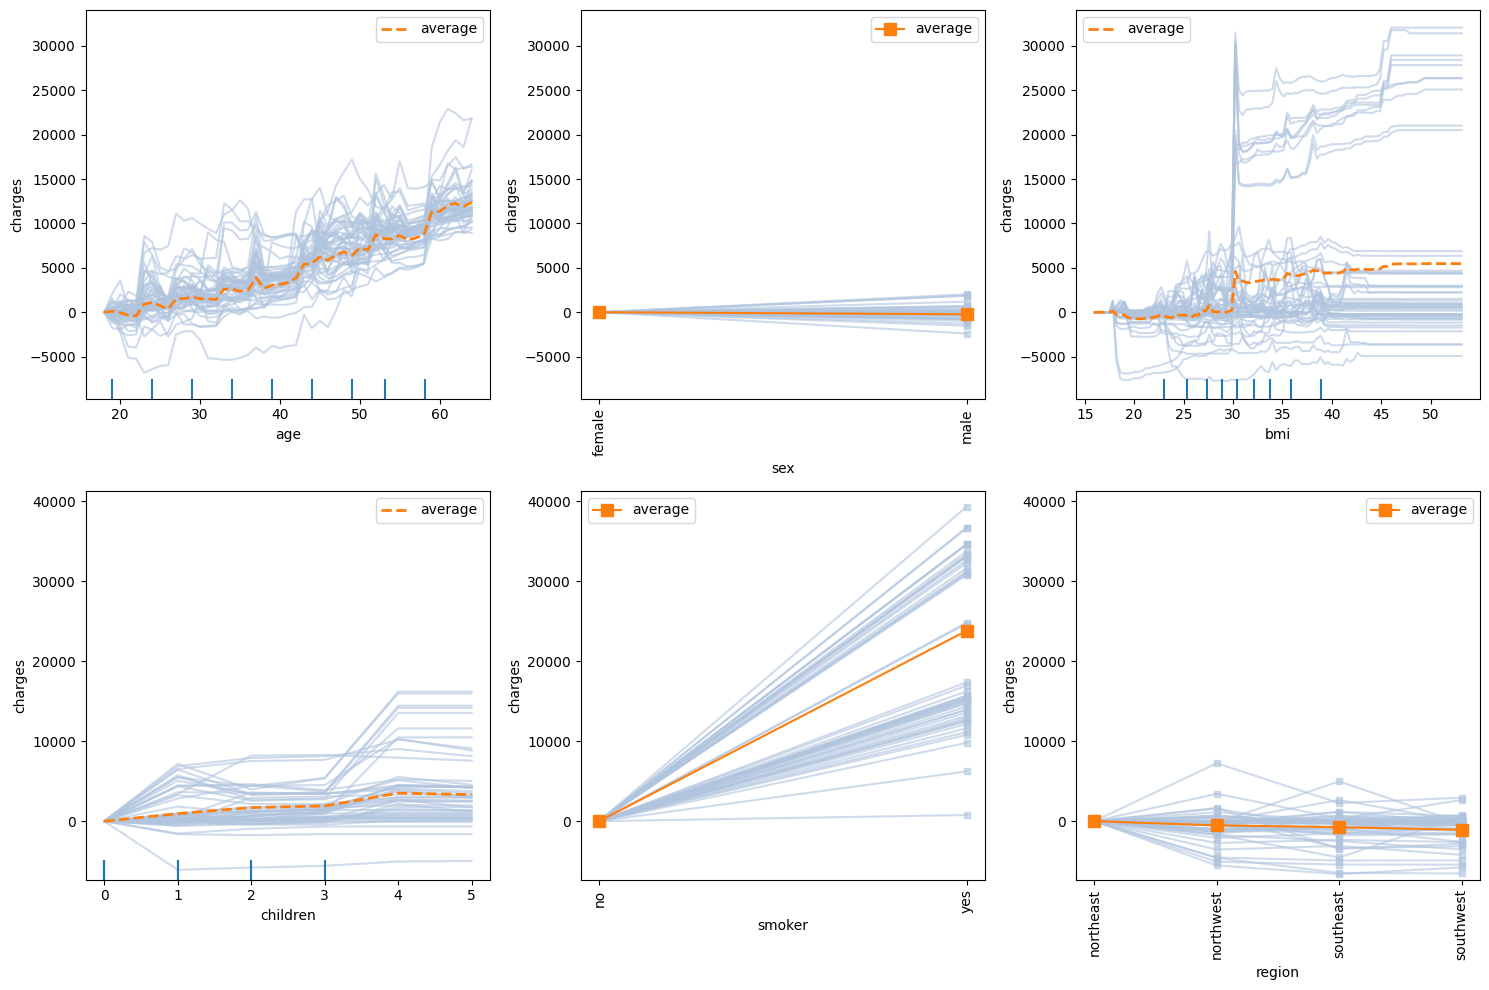

In [42]:
# plot partial dependece curves
# this setup should work for any mode of kind, feel free to alter this to better suit your plot view.
plot_pd(exp=exp,
        n_cols=3,
        n_ice=50,
        sharey='row',
        center = True,
        fig_kw={'figheight': 10, 'figwidth': 15});

### Check Partial Dependence for Two Features
Choose pairs of features to visualize their relationships and interactions with each other. These plots may be a bit confusing so try your best to explain whatever you understand to the TA.

In [50]:
# select combination of features
combined_features = [(feature_names.index('age'), feature_names.index('bmi'))]

In [51]:
# compute explanations
comb_exp = explainer.explain(X=X_train,
                        features=combined_features,
                        kind='average',
                        grid_resolution=25) # kind = [both, individual, average]

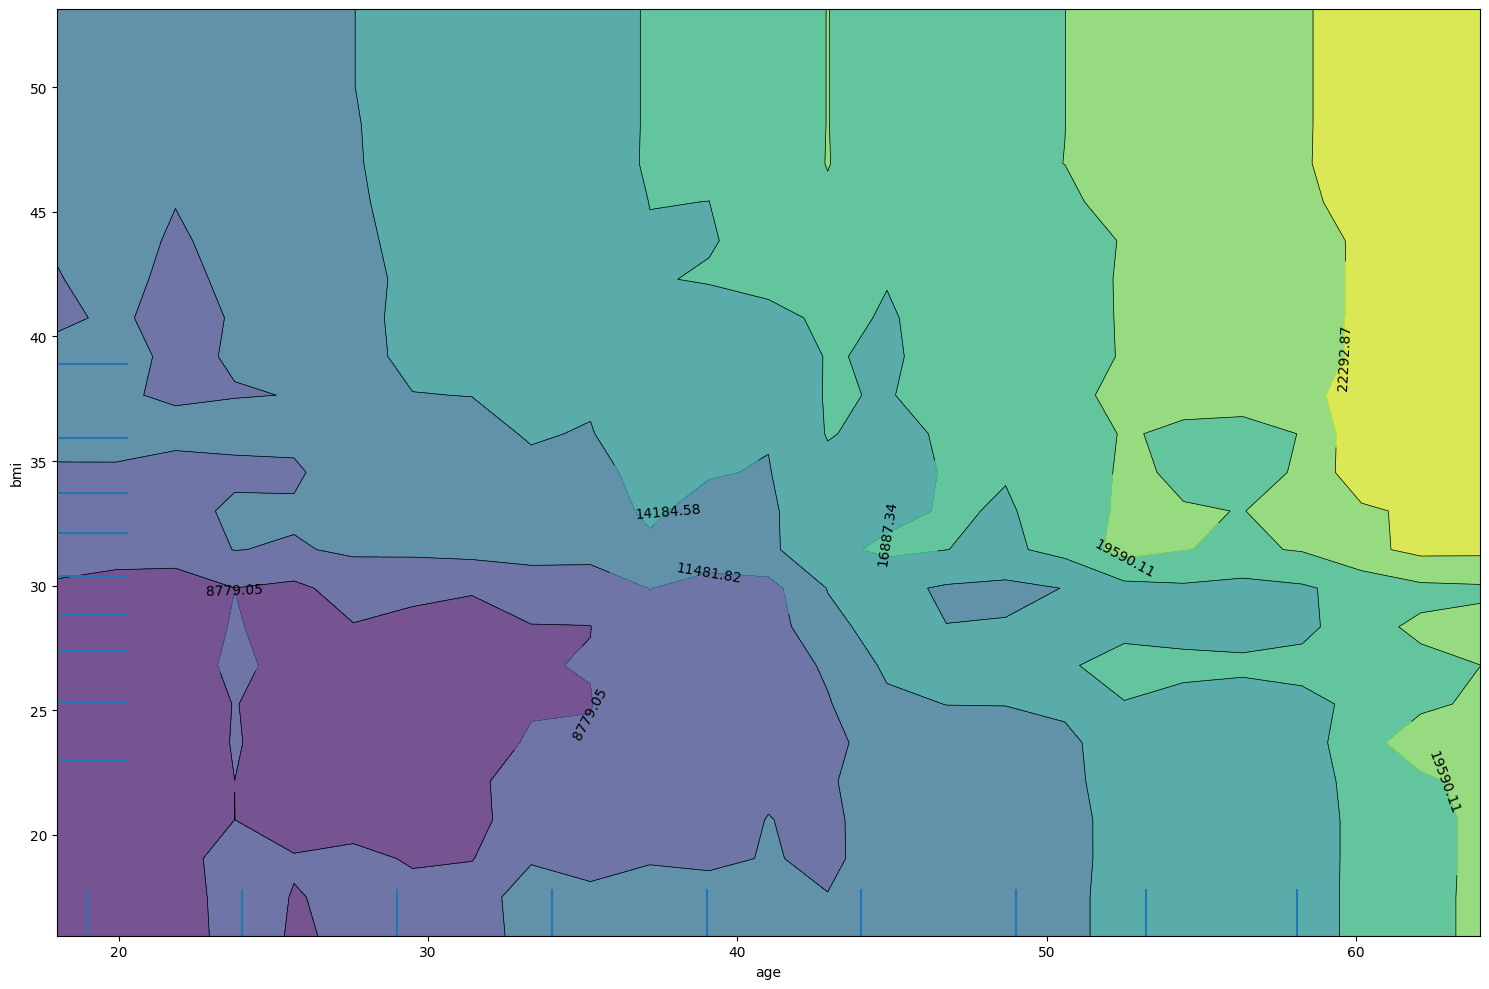

In [52]:
# plot partial dependece curves
plot_pd(exp=comb_exp,
        n_cols=3,
        n_ice=50,
        sharey='row',
        center = True,
        fig_kw={'figheight': 10, 'figwidth': 15});

## 2.2 Anchors
This algorithm provides model-agnostic (black box) and human interpretable explanations suitable for classification models applied to images, text and tabular data. The idea behind anchors is to explain the behaviour of complex models with high-precision rules called anchors. These anchors are locally sufficient conditions to ensure a certain prediction with a high degree of confidence. Run all the cells and play around with parameters to see how this algorithm works.

For this example, we will be explaining predictions from the ImageNet model on the cats dataset.

In [53]:
import tensorflow as tf
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from alibi.datasets import load_cats
from alibi.explainers import AnchorImage

In [54]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 1s 0us/step


In [55]:
image_shape = (299, 299, 3)
data, labels = load_cats(target_size=image_shape[:2], return_X_y=True)
print(f'Images shape: {data.shape}')

Images shape: (4, 299, 299, 3)


In [56]:
images = preprocess_input(data)
preds = model.predict(images)
label = decode_predictions(preds, top=3)
print(label[0])

35363/35363 [==============================] - 0s 0us/step
[('n02123045', 'tabby', 0.8208685), ('n02123159', 'tiger_cat', 0.14372924), ('n02124075', 'Egyptian_cat', 0.016421808)]


In [57]:
# Define prediction function
predict_fn = lambda x: model.predict(x)

In [63]:
segmentation_fn = 'slic' # choose from different segmentation functions - https://scikit-image.org/docs/dev/api/skimage.segmentation.html
kwargs = {'n_segments': 3, 'compactness': 20, 'sigma': .5, 'start_label': 0} # play around with parameters
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=segmentation_fn,
                        segmentation_kwargs=kwargs, images_background=None)

1/1 [==============================] - 0s 443ms/step


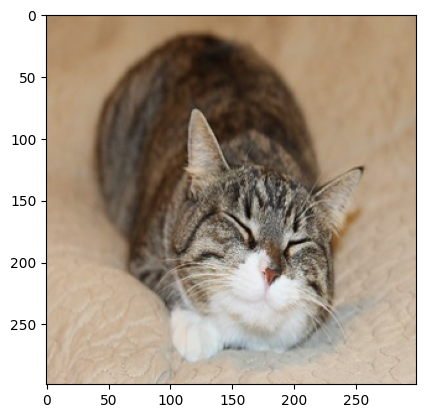

In [64]:
i = 0 # you can change i to choose another picture
plt.imshow(data[i])
plt.show()

In [65]:
image = images[i]
np.random.seed(0)
explanation = explainer.explain(image, threshold=.95, p_sample=.5, tau=0.25) # play around with parameters

4/4 [==============================] - 27s 6s/step


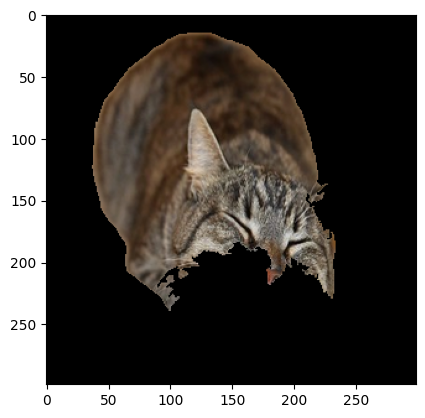

In [66]:
plt.imshow(explanation.anchor);

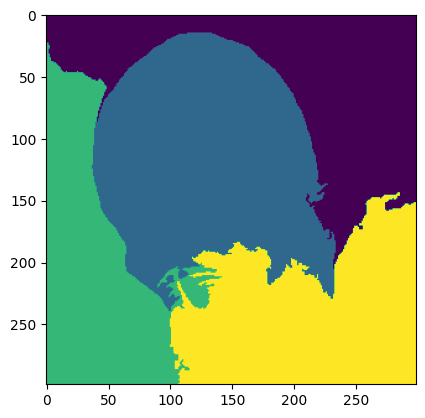

In [67]:
plt.imshow(explanation.segments);

### References
1. https://docs.seldon.io/projects/alibi/en/stable/examples/pdp_regression_bike.html
2. https://docs.seldon.io/projects/alibi/en/stable/methods/PartialDependence.html
3. https://docs.seldon.io/projects/alibi/en/stable/examples/anchor_image_imagenet.html
